In [1]:
using SparseArrays
using LinearAlgebra
using NLopt
using KrylovKit
using Statistics
using FiniteDifferences
using Revise
using TopologyOptimizationHelper

In [2]:
using PyPlot
using DelimitedFiles

In [3]:
function log_LDOS_Optimize(L, ε, ω, b; dpml=0.5, resolution=20, Rpml=1e-20, ftol=1e-4, max_eval=500, design_width=L, fixed_width=0)
    A, x = Maxwell1d(L, ε, ω; dpml, resolution, Rpml)
    D² = A + spdiagm(ω^2 .* ε)
    M = length(x)
    log_LDOS_vals = Float64[]
    log_omegas = ComplexF64[]
    iter = 1
    
    function log_LDOS_obj(ε, grad)
        A = D² - ω^2 * spdiagm(ε)
        LDOS, ∇LDOS = ∇_ε_LDOS(A, ω, b)
        log_LDOS = log(LDOS)

        if !isempty(grad) 
            grad .= ∇LDOS ./ LDOS        
        end
        
        push!(log_LDOS_vals, log_LDOS)

        A_now, _ = Maxwell1d(L, ε, ω; resolution, dpml, Rpml)
        ω₀_now = sqrt(Arnoldi_eig(A_now, ε, ω, b)[1])
        push!(log_omegas, ω₀_now)

        if iter % 100 == 0
            @show iter, LDOS
        end

        iter += 1
        
        return log_LDOS
    end

    design_indices = (-design_width/2 .< x .- mean(x) .< design_width/2) .& .!(-fixed_width/2 .< x .- mean(x) .< fixed_width/2)
    ub = copy(ε)
    lb = copy(ε)
    ub[design_indices] .= 12
    lb[design_indices] .= 1
    opt = Opt(:LD_CCSAQ, M)
    opt.lower_bounds = lb
    opt.upper_bounds = ub
    opt.ftol_rel = ftol
    opt.ftol_abs = ftol
    opt.xtol_rel = ftol
    opt.xtol_abs = ftol
    opt.maxeval = max_eval
    opt.max_objective = log_LDOS_obj

    (log_LDOS_opt, log_ε_opt, ret) = optimize(opt, ε)
    A_opt, _ = Maxwell1d(L, log_ε_opt, ω; resolution, dpml, Rpml)
    ω₀_opt = sqrt(Arnoldi_eig(A_opt, log_ε_opt, ω, b)[1])
    Q_opt = -real(ω₀_opt) / 2imag(ω₀_opt)

    @show numevals = opt.numevals # the number of function evaluations
    @show ω₀_opt
    @show Q_opt
    
    return log_LDOS_opt, log_ε_opt, log_LDOS_vals, log_omegas, x
end

log_LDOS_Optimize (generic function with 1 method)

In [4]:
function mod_log_LDOS_Optimize(L, ε, ω, b, x₀; dpml=0.5, resolution=20, Rpml=1e-20, ftol=1e-4, max_eval=500, ω_pml=ω, design_width=L)
    A, x = Maxwell1d(L, ε, ω; dpml, resolution, Rpml)
    D² = A + ω^2 .* spdiagm(ε)
    M = length(x)
    log_LDOS_vals = Float64[]
    log_omegas = ComplexF64[]

    iter = 1
    function mod_log_LDOS_obj(ε, grad)
        E = spdiagm(ε)
        E⁻¹ = spdiagm(1 ./ ε)
        A = D² - ω^2 .* E
        C = E⁻¹ * A
        LU = lu(C)
        vals, vecs, _ = eigsolve(z -> LU \ z, x₀, 1, :LM, Arnoldi())
        vals = sqrt.(1 ./ vals .+ ω^2)
        ω₀, u₀ = vals[1], vecs[1]
        A₀ = D² - real(ω₀)^2 .* E
        v = A₀ \ b
        w = conj.(v)
        LDOS = -imag(v' * b)
        log_LDOS = log(LDOS)

        if !isempty(grad) 
            ∂LDOS_∂ε = real(ω₀)^2 * imag.(v.^2)
            ∂LDOS_∂ω = -2real(ω₀) * imag(v' * E * w)
            ∂ω_∂ε = -ω₀ .* u₀.^2 ./ 2sum(u₀.^2 .* ε)
            ∇LDOS = ∂LDOS_∂ε .+  ∂LDOS_∂ω .* real.(∂ω_∂ε)

            grad .= ∇LDOS / LDOS
        end

        push!(log_LDOS_vals, log_LDOS)
        push!(log_omegas, ω₀)
        
        if iter % 100 == 0
            @show iter, LDOS
        end
        
        iter += 1
        
        return log_LDOS
    end

    function freq_constraint(ε, grad)        
        ω₀, ∂ω_∂ε = Eigengradient(A, ε, ω, x₀)
        if !isempty(grad) 
            grad .= -real.(∂ω_∂ε) / ω 
        end

        return 1 - real(ω₀) / ω

        # if !isempty(grad) 
        #     grad .= 2real.(∂ω_∂ε) * (real(ω₀) - ω)
        # end

        # return (real(ω₀) - ω)^2 - 5e-1

    end

    design_indices = -design_width / 2 .< x .- mean(x) .< design_width / 2
    ub = ones(M)
    ub[design_indices] .= 12
    
    opt = Opt(:LD_CCSAQ, M)
    # opt.params["verbosity"] = 1
    opt.lower_bounds = 1
    opt.upper_bounds = ub
    opt.ftol_rel = ftol
    opt.ftol_abs = ftol
    opt.xtol_rel = ftol
    opt.xtol_abs = ftol
    opt.maxeval = max_eval
    opt.max_objective = mod_log_LDOS_obj
    opt.initial_step = 1e-1
    inequality_constraint!(opt, freq_constraint)


    (log_LDOS_opt, log_ε_opt, ret) = optimize(opt, ε)
    ω₀ = log_omegas[end]
    Q = -real(ω₀) / 2imag(ω₀)

    @show numevals = opt.numevals # the number of function evaluations
    @show ω₀
    @show Q
    @show ret
    
    return log_LDOS_opt, log_ε_opt, log_LDOS_vals, log_omegas, x
end

mod_log_LDOS_Optimize (generic function with 1 method)

In [5]:
L = 5
res = 50
ε = ones(res * (L + 1))

M = length(ε) 
ω = 2π
_, x = Maxwell1d(L, ε, ω; resolution=res)

b = zeros(M)
b[M÷2] = 1;

In [6]:
ε_vac = ones(M)
A_vac, _ = Maxwell1d(L, ε_vac, ω; resolution=res)
u = A_vac \ b
@show LDOS_vac = -imag(u' * b)

LDOS_vac = -(imag(u' * b)) = 0.0015894422269321887


0.0015894422269321887

In [7]:
custom_epsilon = Fabry_Perot_epsilon.(L, x; λ=1)
A, _ = Maxwell1d(L, custom_epsilon, ω; resolution=res)
ω₀ = sqrt(Arnoldi_eig(A, custom_epsilon, ω, b)[1])
@show Q_fp = -real(ω₀) / 2imag(ω₀)

Q_fp = -(real(ω₀)) / (2 * imag(ω₀)) = 3.9663413059790134e7


3.9663413059790134e7

In [8]:
LDOS_init, ε_init, init_LDOS_vals, init_omegas, x = log_LDOS_Optimize(L, ε, ω, b; resolution=res, ftol=0, max_eval=200)

(iter, LDOS) = (100, 0.5698313392261173)
(iter, LDOS) = (200, 5.660000396211323)
numevals = opt.numevals = 200
ω₀_opt = 6.283189483633811 - 0.00029804921326253615im
Q_opt = 10540.523517670343


(1.7334239622170895, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [-6.444372124966526, -7.081880244654986, -7.3060229231399925, -5.921458317616547, -5.482508141667833, -6.082537612669413, -5.285758172895155, -4.651187884583259, -7.574577028584068, -6.716796904117968  …  1.7185413390575763, 1.5283261281217042, 1.7220000059117198, 1.7300611558533363, 1.461376327977108, 1.7161504826753693, 1.731808959724245, 0.8052594516411131, 1.7252610273371929, 1.7334239622170895], ComplexF64[5.764179529542722 - 2.1834196863707422im, 6.2624622718047585 - 0.09931763879737113im, 6.646046896754592 - 0.19581487275866052im, 6.049571006399429 - 0.2616991178839609im, 6.328108399517975 - 0.27778080499412455im, 6.015745993884492 - 0.1519588985820529im, 6.226479568999578 - 0.22905095543480053im, 6.212494990962934 - 0.10162142325377621im, 6.491259081525111 - 0.02712576468900181im, 6.585969731472339 - 0.1235040014351292im  …  6.28320446270086 - 0.00030125

In [9]:
mod_LDOS_opt, mod_ε_opt, mod_LDOS_vals, mod_omegas, x = mod_log_LDOS_Optimize(L, ε_init, ω, b, b; ftol=0, resolution=res, max_eval=100_000)

(iter, LDOS) = (100, 83.22955908080407)
(iter, LDOS) = (200, 131.91635104015967)
(iter, LDOS) = (300, 163.1015954849429)
(iter, LDOS) = (400, 178.8661213440771)
(iter, LDOS) = (500, 178.86612907703272)
(iter, LDOS) = (600, 178.86614198006868)
(iter, LDOS) = (700, 178.86614198130323)
(iter, LDOS) = (800, 178.86614198130323)
(iter, LDOS) = (900, 178.86614198130323)
(iter, LDOS) = (1000, 178.86614198130323)
(iter, LDOS) = (1100, 178.86614198130323)
(iter, LDOS) = (1200, 178.86614198130323)
(iter, LDOS) = (1300, 178.86614198130323)
(iter, LDOS) = (1400, 178.86614198130323)
(iter, LDOS) = (1500, 178.86614198130323)
(iter, LDOS) = (1600, 178.86614198130323)
(iter, LDOS) = (1700, 178.86614198130323)
(iter, LDOS) = (1800, 178.86614198130323)
(iter, LDOS) = (1900, 178.86614198130323)
(iter, LDOS) = (2000, 178.86614198130323)
(iter, LDOS) = (2100, 178.86614198130323)
(iter, LDOS) = (2200, 178.86614198130323)
(iter, LDOS) = (2300, 178.86614198130323)
(iter, LDOS) = (2400, 178.86614198130323)
(ite

(5.186637715930945, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.7336324777169176, 1.7339088841850523, 1.7348343853831354, 1.7367971498858379, 1.755028228577256, 1.910111166873341, 2.186127480196226, 2.4198149516739518, 2.597202952247798, 2.729846994631589  …  5.186637715930945, 5.186637715930945, 5.186637715930945, 5.186637715930945, 5.186637715930945, 5.186637715930945, 5.186637715930945, 5.186637715930945, 5.186637715930945, 5.186637715930945], ComplexF64[6.283189483633811 - 0.00029804921326253615im, 6.283238918092678 - 0.00029799507574049657im, 6.283275481465752 - 0.0002978372971365819im, 6.283430100974671 - 0.00029745371564523343im, 6.2857417655518475 - 0.0002937547231330554im, 6.291284981289928 - 0.00026637549752118556im, 6.283494264275134 - 0.00022114838540323442im, 6.283622267246596 - 0.00018792803968857002im, 6.283944980751578 - 0.00016504552436194894im, 6.284117032239588 - 0.0001492715474956624im  …  6.28318529827

In [10]:
LDOS_opt, ε_opt, LDOS_vals, omegas, x = log_LDOS_Optimize(L, ε_init, ω, b; resolution=res, ftol=0, max_eval=100_000)

(iter, LDOS) = (100, 5.669208381909811)
(iter, LDOS) = (200, 1.6877610611596316)
(iter, LDOS) = (300, 5.7297134903887805)
(iter, LDOS) = (400, 5.898673373252641)
(iter, LDOS) = (500, 6.31408011228053)
(iter, LDOS) = (600, 2.3610329485557386)
(iter, LDOS) = (700, 6.901124385791071)
(iter, LDOS) = (800, 7.07608576790147)
(iter, LDOS) = (900, 7.1747085672397946)
(iter, LDOS) = (1000, 7.321889649039991)
(iter, LDOS) = (1100, 7.421453367182254)
(iter, LDOS) = (1200, 7.546673658412074)
(iter, LDOS) = (1300, 7.99731098901482)
(iter, LDOS) = (1400, 8.117700878456361)
(iter, LDOS) = (1500, 8.230345305225445)
(iter, LDOS) = (1600, 6.809947986486511)
(iter, LDOS) = (1700, 8.43728631895823)
(iter, LDOS) = (1800, 8.539833734923896)
(iter, LDOS) = (1900, 6.952666845632976)
(iter, LDOS) = (2000, 8.70461007948528)
(iter, LDOS) = (2100, 8.798128717517177)
(iter, LDOS) = (2200, 8.8462841203862)
(iter, LDOS) = (2300, 8.88864761744389)
(iter, LDOS) = (2400, 2.6795516530148524)
(iter, LDOS) = (2500, 9.0212

(3.5126576081877405, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.7334239622170895, -11.83825187051897, -12.443640371885147, -10.972255028180303, -11.960740436099409, -12.31619381087561, -12.574075662238885, -11.188179948674199, -8.91089598586386, -5.432328108666222  …  3.5126486252009683, 3.5126446981583386, 3.5126502900808476, 3.5126142540471177, 3.512651623788941, 3.512639796994065, 3.5126544707532723, 3.507683714348036, 3.512627815984004, 3.5126576081877405], ComplexF64[6.283189483633811 - 0.00029804921326253615im, 6.132941732471693 - 0.0013915574165981957im, 6.437729651482971 - 0.00026547630032846436im, 6.199719498259258 - 0.000874564962545924im, 6.078542606268535 - 0.0005926592402027911im, 6.176103313398175 - 0.0004854041539680565im, 6.5306743679377695 - 0.0009722989246266594im, 6.0690694512196375 - 0.00020213292582586635im, 6.220078059430049 - 0.0002615628090443553im, 6.272404838814126 - 0.0002911850152144969im  …  6

In [11]:
A, x = Maxwell1d(L, ε_init, ω; resolution=res)
@show ω₀_init = sqrt(Arnoldi_eig(A, vec(ε_init), ω, vec(b))[1])
E⁻¹ = spdiagm(1 ./ vec(ε_init))
vals, vecs, info = eigsolve(z -> E⁻¹ * A * z + ω^2 .* z, vec(b), 1, EigSorter(λ -> abs(λ - ω₀_init^2); rev = false), Arnoldi()) 
u_init = abs.(vecs[1]).^2

A, x = Maxwell1d(L, ε_opt, ω; resolution=res)
@show ω₀_opt = sqrt(Arnoldi_eig(A, vec(ε_opt), ω, vec(b))[1])
E⁻¹ = spdiagm(1 ./ vec(ε_opt))
vals, vecs, info = eigsolve(z -> E⁻¹ * A * z + ω^2 .* z, vec(b), 1, EigSorter(λ -> abs(λ - ω₀_opt^2); rev = false), Arnoldi()) 
u_opt = abs.(vecs[1]).^2

A, x = Maxwell1d(L, mod_ε_opt, ω; resolution=res)
@show mod_ω₀_opt = sqrt(Arnoldi_eig(A, vec(mod_ε_opt), ω, vec(b))[1])
E⁻¹ = spdiagm(1 ./ vec(mod_ε_opt))
vals, vecs, info = eigsolve(z -> E⁻¹ * A * z + ω^2 .* z, vec(b), 1, EigSorter(λ -> abs(λ - mod_ω₀_opt^2); rev = false), Arnoldi()) 
mod_u_opt = abs.(vecs[1]).^2

true_max = maximum(vcat(u_init, u_opt, mod_u_opt));

ω₀_init = sqrt((Arnoldi_eig(A, vec(ε_init), ω, vec(b)))[1]) = 6.283189483633811 - 0.00029804921326253615im


┌ Warning: Arnoldi eigsolve stopped without convergence after 100 iterations:
│ * 0 eigenvalues converged
│ * norm of residuals = (4.14e-01)
│ * number of operations = 1218
└ @ KrylovKit C:\Users\jorge\.julia\packages\KrylovKit\jC5gU\src\eigsolve\arnoldi.jl:172


ω₀_opt = sqrt((Arnoldi_eig(A, vec(ε_opt), ω, vec(b)))[1]) = 6.2831852877286085 - 6.146169624349598e-5im
mod_ω₀_opt = sqrt((Arnoldi_eig(A, vec(mod_ε_opt), ω, vec(b)))[1]) = 6.2831852982707534 - 1.8683487965022905e-5im


┌ Warning: Arnoldi eigsolve stopped without convergence after 100 iterations:
│ * 0 eigenvalues converged
│ * norm of residuals = (1.14e-02)
│ * number of operations = 1218
└ @ KrylovKit C:\Users\jorge\.julia\packages\KrylovKit\jC5gU\src\eigsolve\arnoldi.jl:172
┌ Warning: Arnoldi eigsolve stopped without convergence after 100 iterations:
│ * 0 eigenvalues converged
│ * norm of residuals = (2.49e-04)
│ * number of operations = 1218
└ @ KrylovKit C:\Users\jorge\.julia\packages\KrylovKit\jC5gU\src\eigsolve\arnoldi.jl:172


In [12]:
rc("font", family="serif", serif="Times New Roman")
rc("mathtext", fontset="cm")
rc("xtick", labelsize=11.5)  # x-axis tick labels
rc("ytick", labelsize=12)  # y-axis tick labels

sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


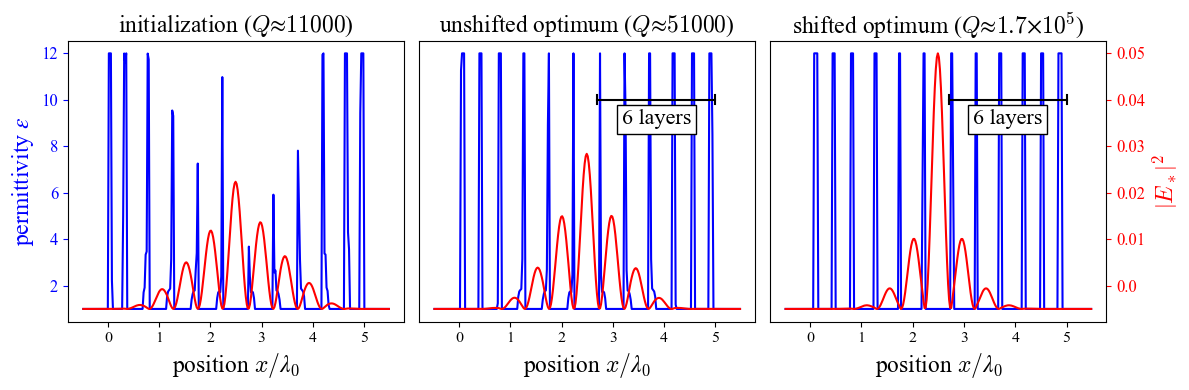

In [13]:
figure(figsize=(12, 4))

subplot(1, 3, 1)
plot(x, ε_init, "b-")
plot(x, (11/true_max)u_init .+ 1, color="red")
title(L"initialization ($Q ≈ 11000$)", fontsize=17)
ylabel(L"permittivity $ε$", color="blue", fontsize=17)
gca().tick_params(axis="y", colors="blue")
xlabel(L"position $x / λ_0$", fontsize=17)


subplot(1, 3, 2)
plot(x, ε_opt, color="blue")
plot(x, (11/true_max)u_opt .+ 1, color="red")
# Main horizontal line
plot([2.7, 5], [10, 10], "k-")

# Bar height
bar_h = 0.4

# Vertical bars at ends
plot([2.7, 2.7], [10 - bar_h/2, 10 + bar_h/2], "k-", lw=1.5)
plot([5, 5], [10 - bar_h/2, 10 + bar_h/2], "k-", lw=1.5)

# Text under the line
text((2.7 + 5)/2, 10 - bar_h, "6 layers", ha="center", va="top", bbox=Dict("facecolor"=>"white", "edgecolor"=>"black", "pad"=>3.2), fontsize=16)

yticks([])
title(L"unshifted optimum ($Q ≈ 51000$)", fontsize=17)
xlabel(L"position $x / λ_0$", fontsize=17)

subplot(1, 3, 3)
plot(x, mod_ε_opt, color="blue")
plot(x, (11/true_max)mod_u_opt .+ 1, color="red")
# Main horizontal line
plot([2.7, 5], [10, 10], "k-")

# Bar height
bar_h = 0.4

# Vertical bars at ends
plot([2.7, 2.7], [10 - bar_h/2, 10 + bar_h/2], "k-", lw=1.5)
plot([5, 5], [10 - bar_h/2, 10 + bar_h/2], "k-", lw=1.5)

# Text under the line
text((2.7 + 5)/2, 10 - bar_h, "6 layers", ha="center", va="top", bbox=Dict("facecolor"=>"white", "edgecolor"=>"black", "pad"=>3.2), fontsize=16)

ylabel(L"$\left|E_*\right|^2$", color="red", fontsize=17)
gca().tick_params(axis="y", colors="red")
gca().yaxis.tick_right()        # move ticks to the right
gca().yaxis.set_label_position("right")  # move label to the right
ytick = gca().get_yticks()
gca().set_yticklabels(string.(round.(true_max .* (ytick .- 1) ./ 11; digits=2)))
title(L"shifted optimum ($Q ≈ 1.7 × 10^5$)", fontsize=17)
xlabel(L"position $x / λ_0$", fontsize=17)

tight_layout()
savefig("log_cavities_1d.pdf", bbox_inches="tight", pad_inches=0)

In [14]:
function make_smooth_plot(lst)
    current = lst[1]
    output = Float64[current]
    for i in 2:length(lst)
        lst_i = lst[i]
        if lst_i > current
            current = lst_i
        end

        push!(output, current)
    end

    return output
end

make_smooth_plot (generic function with 1 method)

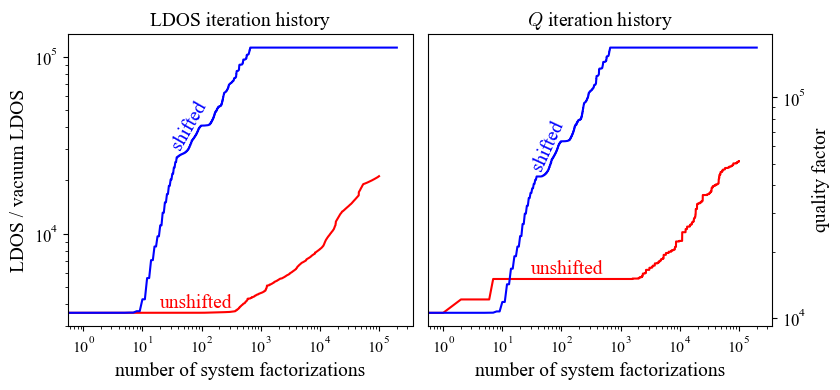

In [15]:
figure(figsize=(8.5, 4))

subplot(1, 2, 1)
loglog(make_smooth_plot(exp.(LDOS_vals)) / LDOS_vac, color="red")
loglog(vcat(fill.(make_smooth_plot(exp.(mod_LDOS_vals)), 2)...) / LDOS_vac, color="blue")
title("LDOS iteration history", fontsize=14)
ylabel("LDOS / vacuum LDOS", fontsize=14)
xlabel("number of system factorizations", fontsize=14)
text(2.7e1, 3e4, "shifted", color="blue", fontsize=14, rotation=60)
text(2e1, 3.8e3, "unshifted", color="red", fontsize=14, rotation=0)

# Right plot
subplot(1, 2, 2)
loglog(make_smooth_plot(-real.(omegas) ./ 2imag.(omegas)), color="red")
loglog(vcat(fill.(make_smooth_plot(-real.(mod_omegas) ./ 2imag.(mod_omegas)), 2)...), color="blue")
title(L"$Q$ iteration history", fontsize=14)
ylabel("quality factor", fontsize=14)
gca().yaxis.tick_right()        # move ticks to the right
gca().yaxis.set_label_position("right")  # move label to the right
xlabel("number of system factorizations", fontsize=14)
text(2.8e1, 4.7e4, "shifted", color="blue", fontsize=14, rotation=65)
text(3e1, 1.58e4, "unshifted", color="red", fontsize=14, rotation=0)

tight_layout()
savefig("log_plots1d.pdf", bbox_inches="tight", pad_inches=0)

In [16]:
function succ_ref(L, L₀, ε_init, ω, b, x₀; resolution=res, max_eval=50, step=1, ftol=1e-4)
    _, ε, LDOS_vals, omegas, x =  log_LDOS_Optimize(L, ε_init, ω, b; resolution, ftol=0, max_eval, design_width=L₀)
    _, mod_ε_opt, mod_LDOS_vals, mod_omegas, _ = mod_log_LDOS_Optimize(L, ε, ω, b, x₀; resolution, max_eval, design_width=L₀ + step, ftol)
    append!(LDOS_vals, mod_LDOS_vals)
    append!(omegas, mod_omegas)
    
    n = 2
    while L₀ + (n-1) * step < L
        log_LDOS, mod_ε_opt, mod_LDOS_vals, mod_omegas, _ = mod_log_LDOS_Optimize(L, mod_ε_opt, ω, b, x₀; resolution, max_eval, design_width=min(L₀ + n * step, L), ftol)
        append!(LDOS_vals, mod_LDOS_vals)
        append!(omegas, mod_omegas)
        n += 1
    end

    return mod_ε_opt, LDOS_vals, omegas
end

succ_ref (generic function with 1 method)

In [17]:
function succ_ref_no_mod(L, L₀, ε_init, ω, b; resolution=res, max_eval=50, step=1, ftol=1e-4, fixed_inner=false)
    _, ε, LDOS_vals, omegas, x =  log_LDOS_Optimize(L, ε_init, ω, b; resolution, ftol=0, max_eval, design_width=L₀)
    _, new_ε_opt, new_LDOS_vals, new_omegas, _ = log_LDOS_Optimize(L, ε, ω, b; resolution, max_eval, design_width=L₀ + step, ftol)
    append!(LDOS_vals, new_LDOS_vals)
    append!(omegas, new_omegas)
    
    n = 2
    while L₀ + (n-1) * step < L
        fixed_width = fixed_inner && n > 2 ? L₀ + (n - 1) * step : 0.0
        LDOS, new_ε_opt, new_LDOS_vals, new_omegas, _ = log_LDOS_Optimize(L, new_ε_opt, ω, b; resolution, max_eval, design_width=min(L₀ + n * step, L), ftol, fixed_width)
        append!(LDOS_vals, new_LDOS_vals)
        append!(omegas, new_omegas)
        n += 1
    end

    return new_ε_opt, LDOS_vals, omegas
end

succ_ref_no_mod (generic function with 1 method)

In [18]:
step = 0.51 ## step = 0.51 best. Test values closer to 0.6

0.51

In [19]:
best_ε_opt, all_LDOS_vals, all_omegas = succ_ref(L, 1, ε, ω, b, b; resolution=res, max_eval=100, step, ftol=0)

(iter, LDOS) = (100, 0.019126018911699426)
numevals = opt.numevals = 100
ω₀_opt = 6.279461077495637 - 0.2621241377930271im
Q_opt = 11.97802905593893
(iter, LDOS) = (100, 0.22694565891174615)
numevals = opt.numevals = 100
ω₀ = 6.2831853106508255 - 0.020057293947470477im
Q = 156.63093254519583
ret = :MAXEVAL_REACHED
(iter, LDOS) = (100, 2.7301071138214925)
numevals = opt.numevals = 100
ω₀ = 6.283185312429284 - 0.001636419923731165im
Q = 1919.796141965545
ret = :MAXEVAL_REACHED
(iter, LDOS) = (100, 29.635332724565647)
numevals = opt.numevals = 100
ω₀ = 6.283185314698197 - 0.00015067882840587513im
Q = 20849.59573010991
ret = :MAXEVAL_REACHED
(iter, LDOS) = (100, 312.8806826004171)
numevals = opt.numevals = 100
ω₀ = 6.283185314870852 - 1.4271164361578524e-5im
Q = 220135.6930548263
ret = :MAXEVAL_REACHED
(iter, LDOS) = (100, 3827.6257452918117)
numevals = opt.numevals = 100
ω₀ = 6.486472523217719 - 1.1743622955387041e-6im
Q = 2.7616999233793695e6
ret = :MAXEVAL_REACHED
(iter, LDOS) = (100, 4

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [-6.444372124966526, -5.997660220657923, -5.512144546625632, -5.643656803978477, -5.091183223452354, -4.08744386690326, -4.182950499780108, -4.048273602223924, -4.409529713757277, -3.9760924974265084  …  13.309826621168263, 13.309826621168263, 13.309826621168263, 13.309826621168263, 13.309826621168263, 13.309826621168263, 13.309826621168263, 13.309826621168263, 13.309826621168263, 13.309826621168263], ComplexF64[5.764179529542722 - 2.1834196863707422im, 5.447536765946505 - 0.9271293103444834im, 6.074542696074801 - 1.0224341658724037im, 5.701784558674168 - 0.3580677864965787im, 6.0195075482592815 - 0.5958064268167917im, 6.267512505598144 - 0.29180378827071957im, 6.148190830499889 - 0.2498963796193456im, 6.197580423226865 - 0.25515692115044775im, 6.483275326771511 - 0.29003634754678714im, 6.266500362889963 - 0.26545191632755216im  …  6.486468822884218 - 7.453340224984247e-9im, 6.4864

In [20]:
new_ε_opt, new_LDOS_vals, new_omegas = succ_ref_no_mod(L, 1, ε, ω, b; resolution=res, max_eval=100, step, ftol=0)

(iter, LDOS) = (100, 0.019126018911699426)
numevals = opt.numevals = 100
ω₀_opt = 6.279461077495637 - 0.2621241377930271im
Q_opt = 11.97802905593893
(iter, LDOS) = (100, 0.2023392846280549)
numevals = opt.numevals = 100
ω₀_opt = 6.28266475054462 - 0.02213879121097693im
Q_opt = 141.89267812032864
(iter, LDOS) = (100, 1.8272546257467164)
numevals = opt.numevals = 100
ω₀_opt = 6.283362861718322 - 0.0024205995936103im
Q_opt = 1297.8938933776217
(iter, LDOS) = (100, 1.4555748974292895)
numevals = opt.numevals = 100
ω₀_opt = 6.283150654422537 - 0.0023069257255474546im
Q_opt = 1361.8016793608488
(iter, LDOS) = (100, 11.380837641355368)
numevals = opt.numevals = 100
ω₀_opt = 6.283043193274884 - 0.00032885077310933913im
Q_opt = 9553.030898890185
(iter, LDOS) = (100, 13.687429283584052)
numevals = opt.numevals = 100
ω₀_opt = 6.283185418941565 - 0.0003244927798854026im
Q_opt = 9681.548879393442
(iter, LDOS) = (100, 15.061007654204085)
numevals = opt.numevals = 100
ω₀_opt = 6.283199431233807 - 0.0

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [-6.444372124966526, -5.997660220657923, -5.512144546625632, -5.643656803978477, -5.091183223452354, -4.08744386690326, -4.182950499780108, -4.048273602223924, -4.409529713757277, -3.9760924974265084  …  3.6615600670597406, 3.794187204955209, 3.7949384423632346, 3.795612605825208, 3.73833770121241, 3.79630610021219, 3.7964286193163663, 3.797370002085598, 3.8052316685988092, -1.6372284033737798], ComplexF64[5.764179529542722 - 2.1834196863707422im, 5.447536765946505 - 0.9271293103444834im, 6.074542696074801 - 1.0224341658724037im, 5.701784558674168 - 0.3580677864965787im, 6.0195075482592815 - 0.5958064268167917im, 6.267512505598144 - 0.29180378827071957im, 6.148190830499889 - 0.2498963796193456im, 6.197580423226865 - 0.25515692115044775im, 6.483275326771511 - 0.29003634754678714im, 6.266500362889963 - 0.26545191632755216im  …  6.283147065597488 - 9.936986707691109e-5im, 6.2831819475

In [21]:
# The eigenpair (ω₀, u₀) solves [E⁻¹A(ω) + ω²I]u₀ = ω₀²u₀
E⁻¹ = spdiagm(1 ./ best_ε_opt)
A, x = Maxwell1d(L, best_ε_opt, ω; resolution=res)
vals, vecs, info = eigsolve(z -> E⁻¹ * A * z + ω^2 .* z, b, 1, EigSorter(λ -> abs(λ - ω^2); rev = false), Arnoldi())
@show ω₀_opt = sqrt(Arnoldi_eig(A, vec(best_ε_opt), ω, vec(b))[1])
u_sr = abs.(vecs[1]).^2

E⁻¹ = spdiagm(1 ./ new_ε_opt)
A, x = Maxwell1d(L, new_ε_opt, ω; resolution=res)
vals, vecs, info = eigsolve(z -> E⁻¹ * A * z + ω^2 .* z, b, 1, EigSorter(λ -> abs(λ - ω^2); rev = false), Arnoldi())
@show ω₀_opt = sqrt(Arnoldi_eig(A, vec(new_ε_opt), ω, vec(b))[1])

u_new = abs.(vecs[1]).^2

E⁻¹ = spdiagm(1 ./ custom_epsilon)
A, x = Maxwell1d(L, custom_epsilon, ω; resolution=res)
vals, vecs, info = eigsolve(z -> E⁻¹ * A * z + ω^2 .* z, b, 1, EigSorter(λ -> abs(λ - ω^2); rev = false), Arnoldi()) 
@show ω₀_opt = sqrt(Arnoldi_eig(A, vec(custom_epsilon), ω, vec(b))[1])

u_fp = abs.(vecs[1]).^2

new_true_max = maximum(vcat(u_fp, u_sr, u_new))

ω₀_opt = sqrt((Arnoldi_eig(A, vec(best_ε_opt), ω, vec(b)))[1]) = 6.486468822884218 - 7.453340224984247e-9im


┌ Warning: Arnoldi eigsolve stopped without convergence after 100 iterations:
│ * 0 eigenvalues converged
│ * norm of residuals = (2.65e-04)
│ * number of operations = 1218
└ @ KrylovKit C:\Users\jorge\.julia\packages\KrylovKit\jC5gU\src\eigsolve\arnoldi.jl:172


ω₀_opt = sqrt((Arnoldi_eig(A, vec(new_ε_opt), ω, vec(b)))[1]) = 6.283188250251619 - 9.872985388125014e-5im


┌ Warning: Arnoldi eigsolve stopped without convergence after 100 iterations:
│ * 0 eigenvalues converged
│ * norm of residuals = (5.41e-04)
│ * number of operations = 1218
└ @ KrylovKit C:\Users\jorge\.julia\packages\KrylovKit\jC5gU\src\eigsolve\arnoldi.jl:172
┌ Warning: Arnoldi eigsolve stopped without convergence after 100 iterations:
│ * 0 eigenvalues converged
│ * norm of residuals = (1.60e-05)
│ * number of operations = 1218
└ @ KrylovKit C:\Users\jorge\.julia\packages\KrylovKit\jC5gU\src\eigsolve\arnoldi.jl:172


ω₀_opt = sqrt((Arnoldi_eig(A, vec(custom_epsilon), ω, vec(b)))[1]) = 6.3327920498469705 - 7.983165796020478e-8im


0.07250202838492469

sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


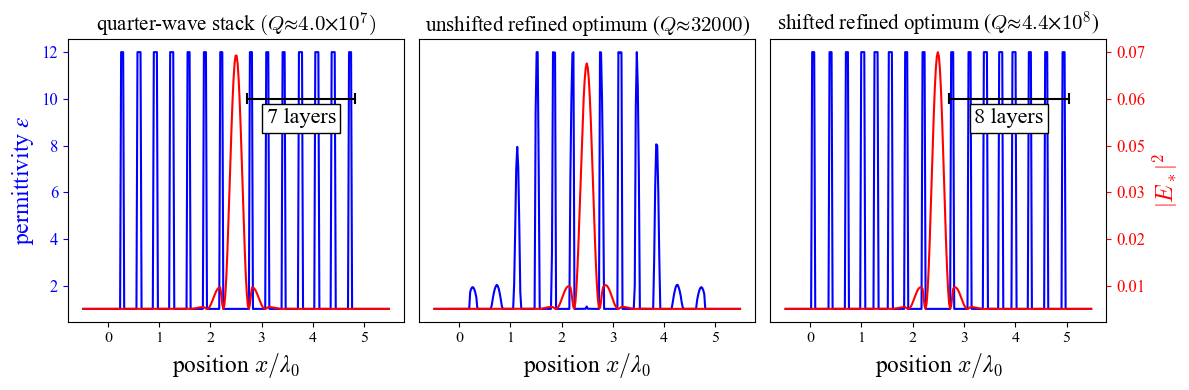

In [22]:
figure(figsize=(12, 4))

subplot(1, 3, 1)
plot(x, custom_epsilon, color="blue")
plot(x, (11/new_true_max)*u_fp .+ 1, color="red")
# Main horizontal line
plot([2.72, 4.825], [10, 10], "k-")

# Bar height
bar_h = 0.4

# Vertical bars at ends
plot([2.72, 2.72], [10 - bar_h/2, 10 + bar_h/2], "k-", lw=1.5)
plot([4.825, 4.825], [10 - bar_h/2, 10 + bar_h/2], "k-", lw=1.5)

# Text under the line
text((2.72 + 4.825)/2, 10 - bar_h, "7 layers", ha="center", va="top", bbox=Dict("facecolor"=>"white", "edgecolor"=>"black", "pad"=>3.2), fontsize=16)

xlabel(L"position $x / λ_0$", fontsize=17)
ylabel(L"permittivity $ε$", color="blue", fontsize=17)
gca().tick_params(axis="y", colors="blue")
title(L"quarter-wave stack $(Q ≈ 4.0 × 10^7)$", fontsize=15)

subplot(1, 3, 2)
plot(x, new_ε_opt, color="blue")
plot(x, (11/new_true_max)*u_new .+ 1, color="red")
xlabel(L"position $x / λ_0$", fontsize=17)
yticks([])
title(L"unshifted refined optimum ($Q ≈ 32000$)", fontsize=15)

subplot(1, 3, 3)
plot(x, best_ε_opt, color="blue")
plot(x, (11/new_true_max)*u_sr .+ 1, color="red")
# Main horizontal line
plot([2.7, 5.05], [10, 10], "k-")

# Bar height
bar_h = 0.4

# Vertical bars at ends
plot([2.7, 2.7], [10 - bar_h/2, 10 + bar_h/2], "k-", lw=1.5)
plot([5.05, 5.05], [10 - bar_h/2, 10 + bar_h/2], "k-", lw=1.5)

# Text under the line
text((2.7 + 5.05)/2, 10 - bar_h, "8 layers", ha="center", va="top", bbox=Dict("facecolor"=>"white", "edgecolor"=>"black", "pad"=>3.2), fontsize=16)

xlabel(L"position $x / λ_0$", fontsize=17)
ylabel(L"$\left|E_*\right|^2$", color="red", fontsize=17)
gca().tick_params(axis="y", colors="red")
gca().yaxis.tick_right()        # move ticks to the right
gca().yaxis.set_label_position("right")  # move label to the right
ytick = gca().get_yticks()
gca().set_yticklabels(string.(round.(new_true_max .* (ytick .- 1) ./ 11; digits=2)))
title(L"shifted refined optimum ($Q ≈ 4.4 × 10^8$)", fontsize=15)

tight_layout()
savefig("log_fabry_succref1d.pdf", bbox_inches="tight", pad_inches=0)

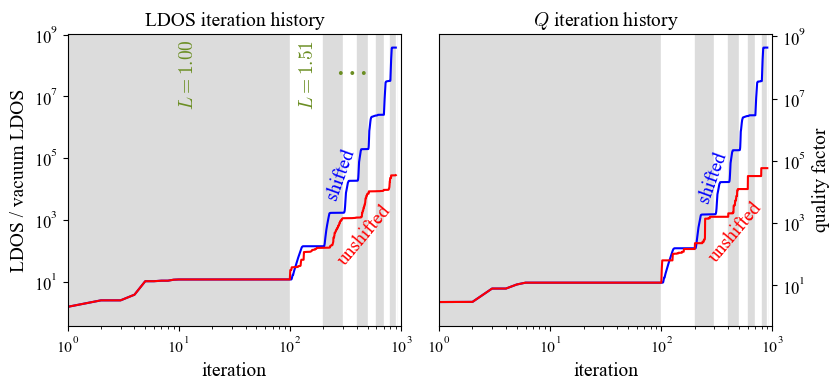

In [23]:
figure(figsize=(8.5, 4))

subplot(1, 2, 1)
loglog(make_smooth_plot(exp.(all_LDOS_vals)) / LDOS_vac, color="blue")
loglog(make_smooth_plot(exp.(new_LDOS_vals)) / LDOS_vac, color="red")
n_iters = length(all_LDOS_vals)
for i in 0:9
    x_start = i * 100
    x_end = min((i + 1) * 100, n_iters)
    color = (i % 2 == 0) ? "gainsboro" : "white"
    axvspan(x_start, x_end, color=color, zorder=0)
end
title("LDOS iteration history", fontsize=14)
xlabel("iteration", fontsize=14)
ylabel("LDOS / vacuum LDOS", fontsize=14)
gca().set_yticks([10.0^k for k in 1:2:9])
gca().tick_params(which="minor", bottom=true, left=false)
text(2e2, 0.5e4, "shifted", color="blue", fontsize=14, rotation=70)
text(2.5e2, 37, "unshifted", color="red", fontsize=14, rotation=50)
xlim(1, 1000)
text(10, 5e6, L"$L = 1.00$", color="olivedrab", fontsize=14, rotation=90)
text(1.22e2, 5e6, L"$L = 1.51$", color="olivedrab", fontsize=14, rotation=90)
text(250, 5e7, L"$…$", color="olivedrab", fontsize=25)


# Right plot
subplot(1, 2, 2)
loglog(make_smooth_plot(-real.(all_omegas) ./ 2imag.(all_omegas)), color="blue")
loglog(make_smooth_plot(-real.(new_omegas) ./ 2imag.(new_omegas)), color="red")
n_iters = length(all_LDOS_vals)
for i in 0:9
    x_start = i * 100
    x_end = min((i + 1) * 100, n_iters)
    color = (i % 2 == 0) ? "gainsboro" : "white"
    axvspan(x_start, x_end, color=color, zorder=0)
end
title(L"$Q$ iteration history", fontsize=14)
xlabel("iteration", fontsize=14)
ylabel("quality factor", fontsize=14)
gca().yaxis.tick_right()        # move ticks to the right
gca().yaxis.set_label_position("right")  # move label to the right
text(2e2, 0.5e4, "shifted", color="blue", fontsize=14, rotation=70)
text(2.5e2, 0.6e2, "unshifted", color="red", fontsize=14, rotation=50)
xlim(1, 1000)

tight_layout()
savefig("log_succ_ref_plot1d.pdf", bbox_inches="tight", pad_inches=0)

In [24]:
function grad_LDOS(L, ε, ω, b; resolution=20)
    A, _ = Maxwell1d(L, ε, ω; resolution)
    v = A \ vec(b)
    w = conj.(v)
    return -ω^2 * imag.(w.^2) / (-imag(v' * b))
end

grad_LDOS (generic function with 1 method)

In [25]:
function grad_mod_LDOS(L, ε, ω, b, x₀; resolution=20)
    E = spdiagm(ε)
    E⁻¹ = spdiagm(1 ./ ε)
    A, _ = Maxwell1d(L, ε, ω; resolution)
    D² = A + ω^2 .* spdiagm(ε)
    C = E⁻¹ * A
    LU = lu(C)

    vals, vecs, _ = eigsolve(z -> LU \ z, x₀, 1, :LM, Arnoldi())
    vals = sqrt.(1 ./ vals .+ ω^2)
    ω₀, u₀ = vals[1], vecs[1]
    A₀ = D² - real(ω₀)^2 .* E
    v = A₀ \ vec(b)
    w = conj.(v)  

    ∂LDOS_∂ε = -imag.(real(ω₀)^2 .* w.^2)
    ∂LDOS_∂ω = -imag(2real(ω₀) .* sum(w.^2 .* conj.(ε)))
    ∂ω_∂ε = -ω₀ .* u₀.^2 ./ 2sum(u₀.^2 .* ε)

    return (∂LDOS_∂ε .+  ∂LDOS_∂ω .* real.(∂ω_∂ε)) / (-imag(v' * b))
end

grad_mod_LDOS (generic function with 1 method)

In [26]:
function Hess_LDOS(L, ε, ω, b; resolution=20)
    n = length(ε)
    Jac = []
    free_idx = findall(x -> x != 1 && x != 12, ε)

    for j in free_idx
        e_j = zeros(n)
        e_j[j] = 1

        f = h -> grad_LDOS(L, ε + h * e_j, ω, b; resolution)
        grad_dir = extrapolate_fdm(central_fdm(10, 1), f, 0)[1]
        push!(Jac, grad_dir[free_idx])
    end

    return hcat(Jac...)
end

Hess_LDOS (generic function with 1 method)

In [27]:
function Hess_mod_LDOS(L, ε, ω, b, x₀; resolution=20)
    n = length(ε)
    Jac = []
    free_idx = findall(x -> x != 1 && x != 12, ε)


    for j in free_idx
        e_j = zeros(n)
        e_j[j] = 1

        f = h -> grad_mod_LDOS(L, ε + h * e_j, ω, b, x₀; resolution)
        grad_dir = extrapolate_fdm(central_fdm(10, 1), f, 0)[1]
        push!(Jac, grad_dir[free_idx])
    end

    return hcat(Jac...)
end

Hess_mod_LDOS (generic function with 1 method)

In [28]:
A, x = Maxwell1d(L, ε_init, ω; resolution=res)
ω₀ = sqrt(Arnoldi_eig(A, ε_init, ω, b)[1])

6.283189483633811 - 0.00029804921326253615im

In [29]:
Hess1 = Hess_LDOS(L, ε_init, real(ω₀), b; resolution=res);

In [30]:
Hess2 = Hess_mod_LDOS(L, ε_init, real(ω₀), b, b; resolution=res);

In [31]:
@show norm(Hess1 - hermitianpart(Hess1)) / norm(Hess1)
SVD1 = svdvals(hermitianpart(Hess1))
@show max_1, min_1 = maximum(SVD1), minimum(SVD1)
κ_1 = max_1 / min_1

norm(Hess1 - hermitianpart(Hess1)) / norm(Hess1) = 1.9481219047696883e-9
(max_1, min_1) = (maximum(SVD1), minimum(SVD1)) = (2.0881036176617052e6, 7.888586607928656e-7)


2.646993335362504e12

In [32]:
@show norm(Hess2 - hermitianpart(Hess2)) / norm(Hess2)
SVD2 = svdvals(hermitianpart(Hess2))
@show max_2, min_2 = maximum(SVD2), minimum(SVD2)
κ_2 = max_2 / min_2

norm(Hess2 - hermitianpart(Hess2)) / norm(Hess2) = 1.2261531831060258e-11
(max_2, min_2) = (maximum(SVD2), minimum(SVD2)) = (2.0326371311212856, 3.083590661660979e-6)


659178.6505237384

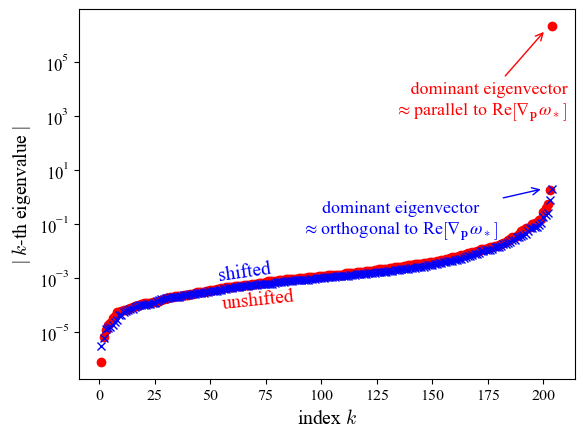

In [33]:
semilogy(1:length(SVD1), reverse(SVD1), "ro")
semilogy(1:length(SVD2), reverse(SVD2), "bx")
xlabel(L"index $k$", fontsize=14)
ylabel(L"| $k$-th eigenvalue |", fontsize=14)
text(53, 8.5e-4, "shifted", color="blue", fontsize=14, rotation=8)
text(55, 7.8e-5, "unshifted", color="red", fontsize=14, rotation=6)

annotate("   dominant eigenvector\n\$≈\$ parallel to Re\$\\left[∇_{\\mathbf{p}} ω_*\\right]\$", 
         xy=(201, 1500000),        # point to
         xytext=(134, 1e3),      # place text at
         color="red",
         arrowprops=Dict("arrowstyle"=>"->", "color"=>"red"),
         fontsize=13)
annotate("    dominant eigenvector\n\$≈\$ orthogonal to Re\$\\left[∇_{\\mathbf{p}} ω_*\\right]\$", 
         xy=(200, 2),        # point to 
         xytext=(92, 4e-2),      # place text at
         color="blue",
         arrowprops=Dict("arrowstyle"=>"->", "color"=>"blue"),
         fontsize=13)


savefig("log_spectrum1d.svg", bbox_inches="tight", pad_inches=0)
savefig("log_spectrum1d.pdf", bbox_inches="tight", pad_inches=0)

In [34]:
u = eigvecs(Hess1)[:,1]
A, _ = Maxwell1d(L, ε_init, real(ω₀); resolution=res)
v = Eigengradient(A, ε_init, real(ω₀), b)[2]
free_idx = findall(x -> 1 < x < 12, ε_init)
v = normalize(real(v[free_idx]))

@show acosd(u' * v), acosd(-u' * v)
@show acos(u' * v), acos(-u' * v)
u' * v

(acosd(u' * v), acosd(-(u') * v)) = (1.7181863193747868e-5, 179.9999828181368)
(acos(u' * v), acos(-(u') * v)) = (2.9988008435812865e-7, 3.141592353709709)


0.999999999999955

In [35]:
u = eigvecs(Hess2)[:,1]
A, _ = Maxwell1d(L, ε_init, real(ω₀); resolution=res)
v = Eigengradient(A, ε_init, real(ω₀), b)[2]
free_idx = findall(x -> 1 < x < 12, ε_init)
v = normalize(real(v[free_idx]))

@show acosd(u' * v), acosd(-u' * v)
@show acos(u' * v), acos(-u' * v)
u' * v

(acosd(u' * v), acosd(-(u') * v)) = (85.93297627868264, 94.06702372131737)
(acos(u' * v), acos(-(u') * v)) = (1.4998133721011964, 1.641779281488597)


0.070923360828152

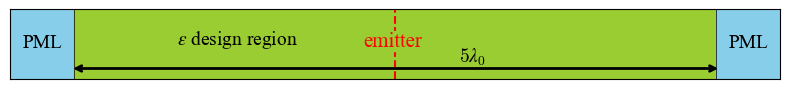

In [36]:
# Set up the figure and axis
figure(figsize=(8, 1))
xlim(-0.5, 5.5)
ylim(0, 1)  # Dummy y-range

# Color regions
axvspan(-0.5, 0, color="skyblue")
axvspan(0, 5, color="yellowgreen")
axvspan(5, 5.5, color="skyblue")
text(-0.4, 0.45, "PML", fontsize=14)
text(5.1, 0.45, "PML", fontsize=14)
text(1-0.2, 0.5, L"$ε$ design region", fontsize=14)
text(2.25, 0.47, "emitter", color="red", bbox=Dict("facecolor" => "yellowgreen", "edgecolor" => "yellowgreen", "boxstyle" => "square, pad=0"), fontsize=15)

# Add red vertical line at center
axvline(x=2.5, color="red", linestyle="--")
axvline(x=0, color="black", linewidth=0.5)
axvline(x=5, color="black", linewidth=0.5)

annotate(
    "",                             # no text
    xy=(-0.03, 0.15),                    # end point
    xytext=(5.04, 0.15),                # start point
    arrowprops=Dict(
        "arrowstyle" => "<->",     # double-headed arrow
        "linewidth" => 2,
        "color" => "black"
    )
)

text(3, 0.25, L"5λ_0", color="black", fontsize=14)

# Add black regions outside full axis (optional, for visual emphasis)
# Here, skyblue padding suffices, but if you meant outer area in black, we’d need figure background color changes.

# Ticks and labels
xticks([])
yticks([])

tight_layout()
savefig("region1d.pdf", bbox_inches="tight", pad_inches=0)